In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats

c:\Users\Kyuho\anaconda3\envs\helix\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [29]:
SEED = 172
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

TRAIN_RATIO = 0.8
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
# LEARNING_RATE = 0.001
EPOCH = 60

ENCODER_PATH = 'C:\\Users\\Kyuho\\code\\UCI\\helix\\variance_predict\\gaussian\\results3\\encoder_epoch_140.pth'
DECODER_PATH = 'C:\\Users\\Kyuho\\code\\UCI\\helix\\variance_predict\\gaussian\\results3\\decoder_epoch_150.pth'
HELIX_PATH = "C:\\Users\\Kyuho\\code\\UCI\\helix\\tracks_100k_updated.txt"
THRESHOLD = 2.5

In [30]:
class Dataset(Dataset):
    def __init__(self, path, transform=None):
        with open(path, 'r') as file:
            content = file.read()
            data_points = content.split('EOT')

            data_points = [dp.strip() for dp in data_points if dp.strip()]
            data_points = [dp.split('\n') for dp in data_points]
            data_points = [[[float(cell) for cell in row.split(', ')] for row in dp] for dp in data_points]
            self.original_targets = np.array([dp[0] for dp in data_points])
            input_points = [dp[1:] for dp in data_points]
            targets_2 = np.delete(self.original_targets, 1, 1)
            targets_2 = np.hstack((targets_2, np.cos(self.original_targets[:, 1])[..., None]))
            targets_cos_sin = np.hstack((targets_2, np.sin(self.original_targets[:, 1])[..., None]))
            self.scaler = MinMaxScaler()
            self.rescaled_targets = self.scaler.fit_transform(targets_cos_sin)
            self.rescaled_targets = torch.tensor(self.rescaled_targets)
            self.original_targets_cos_sin = torch.tensor(targets_cos_sin)
            self.original_targets = torch.tensor(self.original_targets)
            inputs = []
            for input in input_points:
                combined = []
                for coordinate in input:
                    combined += coordinate
                inputs.append(combined)
            self.inputs = torch.tensor(np.array(inputs))
            # self.inputs = torch.tensor(np.array(input_points))

    def __len__(self):
        return len(self.rescaled_targets)

    def __getitem__(self, idx):
        target = self.rescaled_targets[idx]
        input = self.inputs[idx]
        return input, target

In [31]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer1 = nn.Linear(30, 32)
        # self.layer2 = nn.Linear(32, 64)
        # self.layer3 = nn.Linear(64, 5)
        self.layer1_mean = nn.Linear(30, 200)
        self.layer2_mean = nn.Linear(200, 400)
        self.layer3_mean = nn.Linear(400, 800)
        self.layer4_mean = nn.Linear(800, 800)
        self.layer5_mean = nn.Linear(800, 800)
        self.layer6_mean = nn.Linear(800, 400)
        self.layer7_mean = nn.Linear(400, 200)
        self.output_layer_mean = nn.Linear(200, 6)

        # self.layer1_var = nn.Linear(30, 200)
        # self.layer2_var = nn.Linear(200, 400)
        # self.layer3_var = nn.Linear(400, 800)
        # self.layer4_var = nn.Linear(800, 800)
        # self.layer5_var = nn.Linear(800, 800)
        # self.layer6_var = nn.Linear(800, 400)
        # self.layer7_var = nn.Linear(400, 200)
        self.output_layer_var = nn.Linear(200, 6)


    def forward(self, x):
        x = F.leaky_relu(self.layer1_mean(x))
        x = F.leaky_relu(self.layer2_mean(x))
        x = F.leaky_relu(self.layer3_mean(x))
        x = F.leaky_relu(self.layer4_mean(x))
        x = F.leaky_relu(self.layer5_mean(x))
        x = F.leaky_relu(self.layer6_mean(x))
        x = F.leaky_relu(self.layer7_mean(x))
        mean = self.output_layer_mean(x)
        var = F.relu(self.output_layer_var(x))

        return mean, var
    
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        # self.layer1 = nn.Linear(5, 64)
        # self.layer2 = nn.Linear(64, 32)
        # self.layer3 = nn.Linear(32, 30)
        self.layer1 = nn.Linear(12, 200)
        self.layer2 = nn.Linear(200, 200)
        self.layer3 = nn.Linear(200, 200)
        self.layer4 = nn.Linear(200, 400)
        self.layer5 = nn.Linear(400, 800)
        self.layer6 = nn.Linear(800, 800)
        self.layer7 = nn.Linear(800, 800)
        self.layer8 = nn.Linear(800, 400)
        self.layer9 = nn.Linear(400, 200)
        self.output_layer = nn.Linear(200, 30)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        x = F.relu(self.layer6(x))
        x = F.relu(self.layer7(x))
        x = F.relu(self.layer8(x))
        x = F.relu(self.layer9(x))
        x = self.output_layer(x)
        return x

In [32]:
def calc_distance(encoder, decoder, encoder_optimizer, decoder_optimizer, encoder_scheduler, decoder_scheduler, val_dl, device, prev_encoder_path, prev_decoder_path, data_size):
    print(f"Loading model from {prev_encoder_path}")
    checkpoint = torch.load(prev_encoder_path)
    encoder.load_state_dict(checkpoint['model_state_dict'])
    encoder_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"Loading model from {prev_decoder_path}")
    checkpoint = torch.load(prev_decoder_path)
    decoder.load_state_dict(checkpoint['model_state_dict'])
    decoder_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    with torch.no_grad():
        decoder_outputs = torch.zeros(data_size, 10, 3)
        encoder_outputs_mean = torch.zeros(data_size, 6)
        encoder_outputs_var = torch.zeros(data_size, 6)
        distances = torch.zeros(data_size)
        current_size = 0
        for input, target in val_dl:
            input = input.float().to(device)
            target = target.float().to(device)
            mean, variance = encoder(input)
            mean_and_variance = torch.cat((mean, variance), dim=1)
            decoder_output = decoder(mean_and_variance)
            first_dim = torch.numel(decoder_output)  // 30
            decoder_output = decoder_output.reshape(first_dim, 10, 3)
            reshaped_points = input.reshape(first_dim, 10, 3)
            squared_diff = (decoder_output - reshaped_points) ** 2
            pairwise_distances = torch.sqrt(squared_diff.sum(dim=-1))
            distance = pairwise_distances.sum(dim=-1)
            # distance = torch.norm(decoder_output - reshaped_points, 2, dim=(1, 2))
            # distance = torch.sum(torch.square(output_points - reshaped_points), dim=(1, 2))
            distances[current_size:current_size + distance.shape[0]] = distance
            encoder_outputs_mean[current_size:current_size + distance.shape[0], :] = mean
            encoder_outputs_var[current_size:current_size + distance.shape[0], :] = variance
            decoder_outputs[current_size:current_size + target.shape[0], :, :] = decoder_output
            current_size += distance.shape[0]
    
    print(mean_and_variance)
    print(decoder_output)
        
    return encoder_outputs_mean, encoder_outputs_var, decoder_outputs, distances

    # print(distances[-1])
    # print(distances)
    # print(distances.shape)
    # print(torch.mean(distances))
    # print("predictions:", predictions)
    # print("targets:", targets)
    # print("predicted helix but was actually non-helix")
    # predict_helix = predictions == 1
    # wrong = predictions != targets
    # mask = torch.logical_and(predict_helix, wrong)
    # print(predictions[mask].size())
    # print("predicted non-helix but was helix")
    # predict_non_helix = predictions == 0
    # wrong = predictions != targets
    # mask = torch.logical_and(predict_non_helix, wrong)
    # print(predictions[mask].size())
    # print((predictions == targets).float().mean().item())

In [33]:
def run():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    dataset = Dataset(HELIX_PATH)
    train_size = int(TRAIN_RATIO * len(dataset))
    val_size = len(dataset) - train_size

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    encoder = Encoder()
    encoder = encoder.to(device)
    decoder = Decoder()
    decoder = decoder.to(device)

    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()
    encoder_criterion = nn.MSELoss()
    decoder_criterion = nn.MSELoss()
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = LEARNING_RATE)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = LEARNING_RATE)
    encoder_scheduler = torch.optim.lr_scheduler.MultiStepLR(encoder_optimizer, milestones=[15, 30, 50], gamma=0.5)
    decoder_scheduler = torch.optim.lr_scheduler.MultiStepLR(decoder_optimizer, milestones=[15, 30, 50], gamma=0.1)
    
    parameter_prediction, variance_prediction, point_prediction, distances = calc_distance(encoder, decoder, encoder_optimizer, decoder_optimizer, encoder_scheduler, decoder_scheduler, val_dl=dataloader, device=device, 
                  prev_encoder_path=ENCODER_PATH, prev_decoder_path=DECODER_PATH, data_size=len(dataset))

    return parameter_prediction, variance_prediction, point_prediction, distances, dataset

In [34]:
parameters_prediction, variance_prediction, points_prediction, distances, dataset = run()

Using device: cuda
Loading model from C:\Users\Kyuho\code\UCI\helix\variance_predict\gaussian\results3\encoder_epoch_140.pth
Loading model from C:\Users\Kyuho\code\UCI\helix\variance_predict\gaussian\results3\decoder_epoch_150.pth


C:\Users\Kyuho\AppData\Local\Temp\ipykernel_18592\921354270.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(prev_encoder_path)
C:\Users\Kyuho\App

tensor([[0.1661, 0.2318, 0.7179,  ..., 1.3023, 3.1059, 4.3463],
        [0.1215, 0.2321, 0.6225,  ..., 1.1628, 3.0344, 3.9261],
        [0.0725, 0.3328, 0.3681,  ..., 0.2200, 1.7345, 2.2882],
        ...,
        [0.0779, 0.2370, 0.5235,  ..., 0.9456, 2.5989, 3.3827],
        [0.0735, 0.2614, 0.4814,  ..., 0.7595, 2.2770, 3.0198],
        [0.0314, 0.1185, 0.3596,  ..., 0.5233, 2.2108, 2.3248]],
       device='cuda:0')
tensor([[[ 1.5162e-01, -9.9812e-01,  2.2335e-01],
         [ 3.5314e-01, -1.9913e+00, -5.0946e-03],
         [ 6.1949e-01, -2.9642e+00, -2.1087e-01],
         ...,
         [ 3.0039e+00, -7.3915e+00, -1.3013e+00],
         [ 3.6678e+00, -8.1715e+00, -1.5258e+00],
         [ 4.3906e+00, -8.9170e+00, -1.7461e+00]],

        [[ 8.7189e-01, -4.8640e-01, -6.4044e-01],
         [ 1.7512e+00, -9.7379e-01, -7.8705e-01],
         [ 2.6323e+00, -1.4560e+00, -9.3125e-01],
         ...,
         [ 7.1552e+00, -3.5733e+00, -1.6821e+00],
         [ 8.0773e+00, -3.9595e+00, -1.8268e+00]

In [35]:
original_inputs = dataset.inputs.reshape(points_prediction.shape[0], 10, 3)
# print(torch.sqrt(torch.sum(torch.square(points_prediction - original_inputs), dim=(1, 2))))
squared_diff = (points_prediction - original_inputs) ** 2
pairwise_distances = torch.sqrt(squared_diff.sum(dim=-1))
print(pairwise_distances.sum(dim=-1))
print(distances)

tensor([0.9744, 0.8996, 0.4991,  ..., 1.3228, 1.9690, 0.6946],
       dtype=torch.float64)
tensor([0.9744, 0.8996, 0.4991,  ..., 1.3228, 1.9690, 0.6946])


In [36]:
def absolute_difference(prediction, actual):
    return torch.abs(actual - prediction)

def change_trig_to_angle(input):
    cos_values = input[:, 4]
    sin_values = input[:, 5]
    pred_angle = torch.atan2(sin_values, cos_values)
    pred_angle= torch.remainder(pred_angle, np.pi).reshape(input.shape[0], 1)
    return torch.hstack((input[:, 0:1], pred_angle, input[:, 1:4]))

In [37]:
parameters_prediction = dataset.scaler.inverse_transform(parameters_prediction)
parameters_prediction_cos_sin = torch.tensor(parameters_prediction)
parameters_prediction_with_angle = change_trig_to_angle(parameters_prediction_cos_sin)
original_parameters_with_angle = dataset.original_targets

In [41]:
variance_prediction = dataset.scaler.inverse_transform(variance_prediction)

In [42]:
variance_prediction

array([[ 1.73516017e-01,  3.84636824e+02,  4.35953893e+00,
        -9.54468852e-02,  3.65278791e+00,  4.43041321e+00],
       [ 2.26403790e-01,  4.92996930e+02,  4.79345144e+00,
         1.93740769e+00,  5.23760336e+00,  7.22603447e+00],
       [ 1.32186789e-01,  2.91626868e+02, -8.04860220e-01,
         4.74076861e-02,  3.38747064e+00,  3.70533912e+00],
       ...,
       [ 1.84235652e-01,  3.85641504e+02,  2.49943616e+00,
         1.24052516e+00,  4.19788825e+00,  5.76541972e+00],
       [ 1.71844288e-01,  3.51338315e+02,  2.24814881e+00,
         7.28700637e-01,  3.55398874e+00,  5.03950687e+00],
       [ 1.31240118e-01,  2.89702910e+02, -9.97000501e-01,
         7.90894026e-02,  3.42163505e+00,  3.64956547e+00]])

In [39]:
result_mae = torch.mean(absolute_difference(parameters_prediction_with_angle, original_parameters_with_angle), dim=0)
MIN_PER_COLUMN = torch.min(original_parameters_with_angle, dim=0, keepdim=True)
MAX_PER_COLUMN = torch.max(original_parameters_with_angle, dim=0, keepdim=True)
RANGE_PER_COLUMN = (MAX_PER_COLUMN.values - MIN_PER_COLUMN.values)
RANGE_PER_COLUMN_NUMPY = RANGE_PER_COLUMN.numpy()
print(torch.div(result_mae, RANGE_PER_COLUMN) * 100)

def calculate_parameter_error(original, prediction):
    original = np.array(original)
    prediction = np.array(prediction)
    error = np.abs(original - prediction)
    return error / RANGE_PER_COLUMN_NUMPY * 100

tensor([[10.5475, 26.5612, 33.3716, 13.2761,  8.0200]], dtype=torch.float64)


In [40]:
RANGE_PER_COLUMN

tensor([[5.1100e-02, 6.2800e+00, 1.7499e+02, 8.8100e+00, 2.7500e+00]],
       dtype=torch.float64)

In [43]:
list_distances = distances.tolist()
list_original_parameters_with_angle = original_parameters_with_angle.tolist()
list_original_inputs = original_inputs.tolist()
list_parameters_prediction = parameters_prediction_with_angle.tolist()
list_points_prediction = points_prediction.tolist()
list_variance_prediction = variance_prediction.tolist()

In [44]:
combined = zip(list_distances, list_original_parameters_with_angle, list_original_inputs, list_parameters_prediction, list_variance_prediction, list_points_prediction)
sorted_combined = sorted(combined)

In [45]:
min_r0=1.0
max_r0=10.0
nlayers=10
sigma=0.01

def track(phi, d0,phi0,pt,dz,tanl):
    alpha = 1/2 # 1/cB
    q=1
    kappa = q/pt
    rho = alpha/kappa
    x = d0*np.cos(phi0) + rho*(np.cos(phi0)-np.cos(phi0+phi))
    y = d0*np.sin(phi0) + rho*(np.sin(phi0)-np.sin(phi0+phi))
    z = dz - rho*tanl*phi
    return x,y,z

def dr(phi, r02,d0,phi0,pt,dz,tanl):

    # get the xyz of the track at this phi
    x,y,z = track(phi, d0,phi0,pt,dz,tanl)
    r2=x*x+y*y

    # get the distance from the target r02
    dr = np.fabs(r2-r02)

    return dr

def find_phi(r0, d0,phi0,pt,dz,tanl):

    # this is lazy, but rather than inverting the equations we just minimize the distance
    res = scipy.optimize.minimize(dr,0,method='Nelder-Mead',args = (r0, d0,phi0,pt,dz,tanl))#, bounds =(0,1.0))

    return res.x[0]


# find the intersections with the detector layers for these track parameters, add noise
def make_hits(params):
    xs=[]
    ys=[]
    zs =[]
    
    for r0 in np.linspace(min_r0,max_r0,nlayers):
        phi0 = find_phi(r0*r0,*params)
        x0,y0,z0 = track(phi0,*params)
        xs.append(x0)
        ys.append(y0)
        zs.append(z0)


    return xs,ys,zs

In [51]:
def separateXYZ(combined):
    x = [x for x, y, z in combined]
    y = [y for x, y, z in combined]
    z = [z for x, y, z in combined]

    return x, y, z

def plotTracks(combined):
    distances, original_targets, original_points, predicted_targets, predicted_variance, predicted_points = combined
    original_x, original_y, original_z = make_hits(original_targets)
    pred_x, pred_y, pred_z = make_hits(predicted_targets)

    figure, axis = plt.subplots(1, 2)
    axis[0].plot(original_x,original_y,".",color='green')
    axis[0].plot(pred_x,pred_y,"x",color='red')
    axis[0].legend(["original xy", "predicted_xy"])
    axis[0].set_xlim(-10, 10)
    axis[0].set_ylim(-10, 10)

    axis[1].plot(original_x,original_z,".",color='green')
    axis[1].plot(pred_x,pred_z,"x",color='red')
    axis[1].legend(["original xz", "predicted_xz"])
    axis[1].set_xlim(-10, 10)
    axis[1].set_ylim(-10, 10)
    plt.show()


def plotPoints(combined):
    distances, original_targets, original_points, predicted_targets, predicted_variance, predicted_points = combined
    original_x, original_y, original_z = separateXYZ(original_points)
    pred_x, pred_y, pred_z = separateXYZ(predicted_points)

    original_param_x, original_param_y, original_param_z = make_hits(original_targets)
    pred_param_x, pred_param_y, pred_param_z = make_hits(predicted_targets)

    print("original:", original_targets)
    print("predicted:", predicted_targets)
    print("error:", calculate_parameter_error(original_targets, predicted_targets))
    print("distance:", distances)
    print("variance:", predicted_variance)

    figure, axis = plt.subplots(1, 2)
    axis[0].plot(original_x,original_y,".",color='green')
    axis[0].plot(pred_x,pred_y,".",color='red')
    # axis[0].plot(original_param_x,original_param_y,"x",color='blue')
    # axis[0].plot(pred_param_x,pred_param_y,"x",color='orange')
    axis[0].legend(["original xy", "predicted_xy"])
    axis[0].set_xlim(-10, 10)
    axis[0].set_ylim(-10, 10)

    axis[1].plot(original_x,original_z,".",color='green')
    axis[1].plot(pred_x,pred_z,".",color='red')
    # axis[1].plot(original_param_x,original_param_z,"x",color='blue')
    # axis[1].plot(pred_param_x,pred_param_z,"x",color='orange')
    axis[1].legend(["original xz", "predicted_xz"])
    axis[1].set_xlim(-10, 10)
    axis[1].set_ylim(-10, 10)
    plt.show()


original: [0.0006, 4.43, 155.27, 2.87, -1.06]
predicted: [0.006423769354820251, 1.5805213508352565, 74.080462051332, 0.5583729743957521, -0.7575397497415545]
error: [[11.39680891 45.37386384 46.39667292 26.23867225 10.99855455]]
distance: 10.023906707763672
variance: [0.18483166577816007, 409.3930687785148, 3.490008320808411, 0.4692103260755537, 3.6507027029424126, 5.609983448135953]


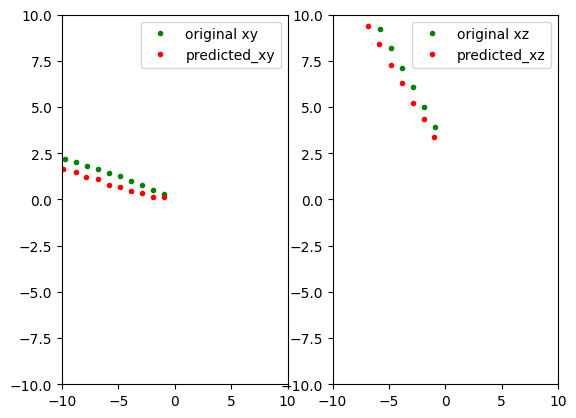

In [57]:
target = sorted_combined[-1]
plotPoints(target)